# Init

In [43]:
!pip install --upgrade gensim
!pip install tqdm
!pip install -U pyLDAvis

In [56]:
import pickle

import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
import gensim

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.lda_model

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [23]:
with open('pickle/df_proc.p', 'rb') as file:
    df = pickle.load(file)
df.head()

,text
0,programa treinamento jornalismo agroindústria ...
1,ofício enviado sergio presidente michel esquiv...
2,governador sérgio cabral transferido complexo ...
3,aplausos federal sergio responsável operação i...
4,executivo empreiteira odebrecht afirmou acordo...


# Process LDA

In [24]:
tokenized_docs = [doc.lower().split() for doc in df['text']]

In [25]:
id2word = corpora.Dictionary(tokenized_docs)
corpus = [id2word.doc2bow(text) for text in tokenized_docs]

In [26]:
def compute_coherence_values(corpus, dictionary, texts, range_lda):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range_lda):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [27]:
limit=21; start=2; step=1;
range_lda = range(start, limit, step)
model_list, coherence_values = compute_coherence_values(corpus=corpus, dictionary=id2word, texts=tokenized_docs, range_lda=range_lda)

100%|██████████| 19/19 [01:44<00:00,  5.51s/it]


# Visualize Results

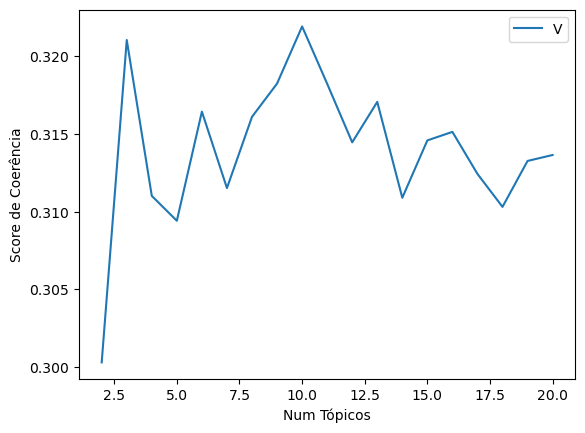

In [28]:
x = range_lda
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [29]:
for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.3003
A quantidade de tópicos = 3  tem um valor de coerência de  0.321
A quantidade de tópicos = 4  tem um valor de coerência de  0.311
A quantidade de tópicos = 5  tem um valor de coerência de  0.3094
A quantidade de tópicos = 6  tem um valor de coerência de  0.3164
A quantidade de tópicos = 7  tem um valor de coerência de  0.3115
A quantidade de tópicos = 8  tem um valor de coerência de  0.3161
A quantidade de tópicos = 9  tem um valor de coerência de  0.3182
A quantidade de tópicos = 10  tem um valor de coerência de  0.3219
A quantidade de tópicos = 11  tem um valor de coerência de  0.3182
A quantidade de tópicos = 12  tem um valor de coerência de  0.3145
A quantidade de tópicos = 13  tem um valor de coerência de  0.3171
A quantidade de tópicos = 14  tem um valor de coerência de  0.3109
A quantidade de tópicos = 15  tem um valor de coerência de  0.3146
A quantidade de tópicos = 16  tem um valor de coerência de  0.3151
A qua

# Save best model

In [30]:
optimal_model_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[optimal_model_index]
optimal_num_topics = optimal_model.num_topics

print(f"Melhor número de tópicos: {optimal_num_topics}")

with open('pickle/optimal_model.p', 'wb') as file:
    pickle.dump(optimal_model, file)

Melhor número de tópicos: 10


# Visualize Words

In [31]:
def get_topic_words(lda_model, num_words=5):
    topic_words = {}
    for i, topic in enumerate(lda_model.show_topics(formatted=False, num_words=num_words)):
        topic_words[i] = [word for word, _ in topic[1]]
    return topic_words

In [32]:
topic_words = get_topic_words(optimal_model, num_words=5)

for topic, words in topic_words.items():
    print(f"Tópico {topic}: {' '.join(words)}")

Tópico 0: presidente governo pessoas brasil semana
Tópico 1: governo presidente brasil milhões cidade
Tópico 2: presidente brasil governo afirmou pessoas
Tópico 3: brasil presidente governo afirmou pessoas
Tópico 4: brasil presidente pessoas milhões governo
Tópico 5: presidente governo brasil pessoas processo
Tópico 6: presidente governo brasil milhões pessoas
Tópico 7: brasil presidente pessoas cidade afirmou
Tópico 8: governo presidente afirmou ministro brasil
Tópico 9: presidente brasil governo pessoas trabalho


# LDAvys

In [57]:
tf_vectorizer = CountVectorizer(max_features=5000)
vect_text = tf_vectorizer.fit_transform(df['text'])

In [58]:
lda = LatentDirichletAllocation(n_components=10, learning_method='batch', random_state=0)
lda.fit(vect_text)
doc_topic_matrix = lda.transform(vect_text)

In [60]:
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda, vect_text, tf_vectorizer, sort_topics=False, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0     -55.607620  75.936554       1        1   8.997502
1      76.480232 -31.692591       2        1  10.447221
2     -24.722685  23.277275       3        1   6.382567
3      17.904669  82.501266       4        1   9.540702
4       0.987357 -30.617058       5        1  14.514285
5     -50.629833 -65.020027       6        1  11.233756
6      34.823902  18.490025       7        1  13.385327
7      88.005791  46.890991       8        1   8.199738
8      27.879868 -85.621613       9        1   8.378026
9     -81.740578  -1.822353      10        1   8.920877, topic_info=            Term         Freq        Total Category  logprob  loglift
2424     governo  7153.000000  7153.000000  Default  30.0000  30.0000
3813  presidente  8571.000000  8571.000000  Default  29.0000  29.0000
1805     empresa  3151.000000  3151.000000  Default  28.0000  28.0000
3719     polícia  2354.000000  2354.000000  Default  27.0000  27.0000
689     campanha  2315.000000  2315.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
4008     pública   401.811259  1396.918170  Topic10  -5.5538   1.1707
1590    dinheiro   426.833624  2009.124282  Topic10  -5.4934   0.8677
3912    programa   404.771914  1814.616535  Topic10  -5.5465   0.9165
3266    nacional   436.194786  2682.651739  Topic10  -5.4717   0.6003
4010     público   442.740764  3219.920334  Topic10  -5.4568   0.4326

[705 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
41        1  0.820147  acidente
41        2  0.085210  acidente
41        4  0.013314  acidente
41        5  0.055919  acidente
41        6  0.021303  acidente
...     ...       ...       ...
4995      2  0.002877    ônibus
4995      4  0.158213    ônibus
4995      5  0.046026    ônibus
4995      8  0.162528    ônibus
4995     10  0.001438    ônibus

[2592 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])